# Aula 1 - Criando um gerador

## Vídeo 1.2 - Carregando o fmnist

In [3]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [28]:
# Carregar o dataset Fashion MNIST
(train_images, train_labels), _ = tf.keras.datasets.fashion_mnist.load_data()

# Normalizar as imagens para o intervalo [-1, 1]
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalizar para [-1, 1]

# Definir o batch size e preparar o dataset para treinamento
batch_size = 256

# Criar o dataset de treino
train_ds = tf.data.Dataset.from_tensor_slices(train_images).shuffle(60000).batch(batch_size)

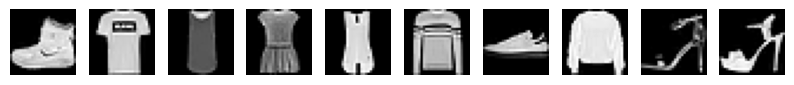

In [5]:
# Exibir algumas imagens de exemplo
num_images_to_show = 10
plt.figure(figsize=(10, 10))
for i in range(num_images_to_show):
    plt.subplot(1, num_images_to_show, i + 1)
    plt.imshow(train_images[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
plt.show()

## Vídeo 1.3 - Estruturando um gerador

In [6]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [8]:
def constroi_gerador():
    modelo = Sequential()

    modelo.add(layers.Input(shape=(100,)))
    modelo.add(layers.Dense(7*7*256, use_bias=False))
    modelo.add(layers.BatchNormalization())
    modelo.add(layers.LeakyReLU())

    modelo.add(layers.Reshape((7, 7, 256)))
    modelo.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    modelo.add(layers.BatchNormalization())
    modelo.add(layers.LeakyReLU())

    modelo.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    modelo.add(layers.BatchNormalization())
    modelo.add(layers.LeakyReLU())

    modelo.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    return modelo


## Vídeo 1.4 - Gerando uma imagem

In [9]:
# Criação do gerador
gerador = constroi_gerador()

In [10]:
# Gerar Vetor de Ruído
dimensao_ruido = 100
ruido = tf.random.normal([1, dimensao_ruido])

In [11]:
# Gerar imagem a partir do vetor de ruído
imagem_gerada = gerador(ruido, training=False)

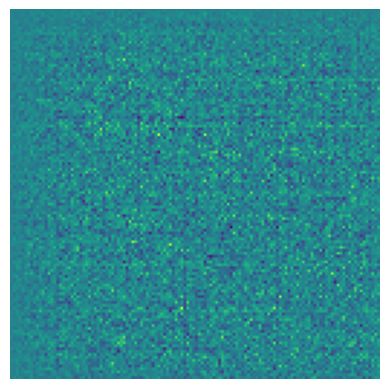

In [16]:
# Visualizar a imagem gerada
import matplotlib.pyplot as plt
plt.imshow((imagem_gerada[0] * 127.5 + 127.5).numpy())
plt.axis('off')
plt.show()

# Aula 2 - Implementando um discriminador

## Vídeo 2.1 - Criando a função do discriminador

In [12]:
def constroi_discriminador():
    modelo = Sequential()

    modelo = Sequential()

    modelo.add(layers.Input(shape=(28, 28, 1)))
    modelo.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same'))
    modelo.add(layers.LeakyReLU())
    modelo.add(layers.Dropout(0.3))

    modelo.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    modelo.add(layers.LeakyReLU())
    modelo.add(layers.Dropout(0.3))

    # Corrigir a dimensão da Flatten para compatibilizar com a Dense
    modelo.add(layers.Flatten())
    modelo.add(layers.Dense(1))

    return modelo

In [13]:
discriminador = constroi_discriminador()
decisao = discriminador(imagem_gerada)
print(decisao)

tf.Tensor([[-0.00100413]], shape=(1, 1), dtype=float32)


## Vídeo 2.2 - Definindo as funções de custo

In [14]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [15]:
def custo_discriminador(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [16]:
def custo_gerador(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [18]:
otimizador_gerador = tf.keras.optimizers.Adam(1e-4)
otimizador_discriminador = tf.keras.optimizers.Adam(1e-4)

In [19]:
import os

In [20]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=otimizador_gerador,
                                 discriminator_optimizer=otimizador_discriminador,
                                 generator=gerador,
                                 discriminator=discriminador)

## Vídeo 2.3 - Definindo um loop de treinamento

In [21]:
epocas = 50
dimensao_ruido = 100
numero_exemplos_treinamento = 16

#Vetor de ruido para gerar imagens
seed = tf.random.normal([numero_exemplos_treinamento, dimensao_ruido])

In [22]:
@tf.function
def passo_treino(images):
    ruido = tf.random.normal([batch_size, dimensao_ruido])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = gerador(ruido, training=True)

        real_output = discriminador(images, training=True)
        fake_output = discriminador(generated_images, training=True)

        gen_loss = custo_gerador(fake_output)
        disc_loss = custo_discriminador(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, gerador.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminador.trainable_variables)

    otimizador_gerador.apply_gradients(zip(gradients_of_generator, gerador.trainable_variables))
    otimizador_discriminador.apply_gradients(zip(gradients_of_discriminator, discriminador.trainable_variables))

In [23]:
import time
from IPython.display import clear_output

In [24]:
def treino(dataset, epocas):
    for epoca in range(epocas):
        start = time.time()

        for image_batch in dataset:
           passo_treino(image_batch)

        # Produz as imagens para gerar um gif
        clear_output(wait=True)
        gera_e_salva_imagens(gerador,
                                 epoca + 1,
                                 seed)

        # Salva o modelo a cada 15 épocas
        if (epoca + 1) % 15 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        print('Tempo por época {} é {} s'.format(epoca + 1, time.time()-start))

    # Gera após a época final
    clear_output(wait=True)
    gera_e_salva_imagens(gerador,
                                 epoca + 1,
                                 seed)

In [25]:
def gera_e_salva_imagens(modelo, epoca, entrada):
  # Observe que `training` está definido como False.
  # Isso é para que todas as camadas sejam executadas no modo de inferência (batchnorm).
  previsao = modelo(entrada, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(previsao.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(previsao[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoca))
  plt.show()

## Vídeo 2.4 - Aplicando o treinamento

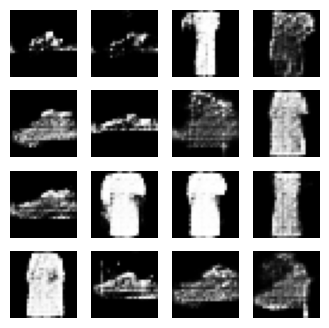

In [29]:
treino(train_ds, epocas)

In [30]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))


In [38]:
gerador.save('modelo_gerador.keras')

In [39]:
from tensorflow.keras.models import load_model

gerador_carregado = load_model('modelo_gerador.keras')

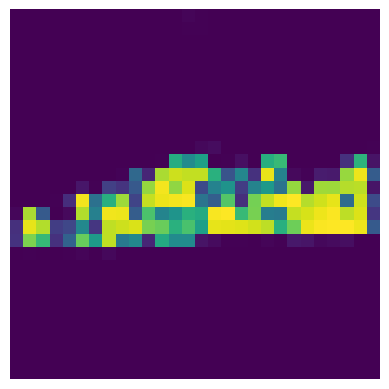

In [42]:
# Gerar um novo vetor de ruído
new_noise = tf.random.normal([1, dimensao_ruido])

# Gerar uma nova imagem usando o modelo carregado
new_generated_image = gerador_carregado(new_noise, training=False)

# Visualizar a nova imagem gerada
plt.imshow((new_generated_image[0] * 127.5 + 127.5).numpy())
plt.axis('off')
plt.show()


# Aula 3 - Construindo um difusor

## Vídeo 3.1 - Adicionando de ruído

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tqdm.auto import trange, tqdm

2024-09-17 14:15:25.149580: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-17 14:15:25.149817: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-17 14:15:25.179909: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-17 14:15:25.255596: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-17 14:15:26.219331: W tensorflow/compiler/tf2

In [2]:
# Carregando o dataset Fashion MNIST
(X_treino, y_treino), (X_teste, y_teste) = tf.keras.datasets.fashion_mnist.load_data()
# Normalizando as imagens para o intervalo [-1, 1]
X_treino = (X_treino / 127.5) - 1.0

# Adicionando um canal extra para as imagens de 28x28
X_treino = np.expand_dims(X_treino, axis=-1)

In [3]:
IMG_SIZE = 28     # Tamanho das imagens de entrada, Fashion MNIST é 28x28
BATCH_SIZE = 128  # Tamanho do lote para treinamento
timesteps = 16    # Quantidade de passos para uma imagem ruidosa se tornar clara
time_bar = 1 - np.linspace(0, 1.0, timesteps + 1) # linspace para timesteps

In [4]:
def cvtImg(img):
    img = img - img.min()
    img = (img / img.max())
    return img.astype(np.float32)

In [5]:
def show_examples(x):
    num_images = x.shape[0]
    plt.figure(figsize=(10, 10))
    for i in range(min(25, num_images)):  # Mostra no máximo 25 imagens
        plt.subplot(5, 5, i+1)
        img = cvtImg(x[i])
        plt.imshow(img.squeeze(), cmap='gray')  # Exibe como imagem em escala de cinza
        plt.axis('off')

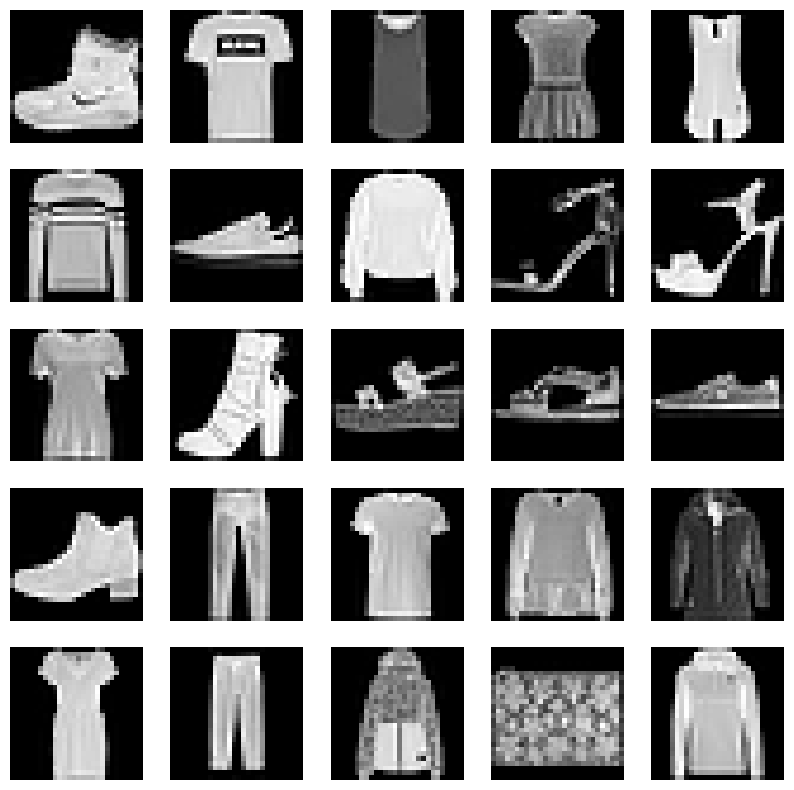

In [6]:
show_examples(X_treino)

In [7]:
def forward_noise(x, t):
    a = time_bar[t]      # imagem no tempo t
    b = time_bar[t + 1]  # imagem em t + 1

    ruido = np.random.normal(size=x.shape)  # Gera máscara de ruído
    a = a.reshape((-1, 1, 1, 1))
    b = b.reshape((-1, 1, 1, 1))
    img_a = x * (1 - a) + ruido * a
    img_b = x * (1 - b) + ruido * b
    return img_a, img_b

In [8]:
def generate_ts(num):
    return np.random.randint(0, timesteps, size=num)

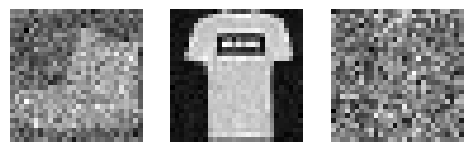

In [10]:
# Gera exemplos de treino
t = generate_ts(3)  # Gera timesteps para 25 exemplos
a, b = forward_noise(X_treino[:3], t)
show_examples(a)

## Vídeo 3.2 - Implementando uma U-net

In [11]:
def block(x):
    x = layers.Conv2D(128, kernel_size=3, padding='same')(x)
    x = layers.LayerNormalization()(x)
    x = layers.Activation('relu')(x)
    return x

In [12]:
def make_model():
    # Ajuste na entrada para Fashion MNIST
    x = x_input = layers.Input(shape=(28, 28, 1), name='x_input')

    x_ts = x_ts_input = layers.Input(shape=(1,), name='x_ts_input')
    x_ts = layers.Dense(192)(x_ts)
    x_ts = layers.LayerNormalization()(x_ts)
    x_ts = layers.Activation('relu')(x_ts)

    # ----- left ( down ) -----
    x = x28 = block(x)  # 28x28 -> 28x28
    x = layers.MaxPool2D(2, padding='same')(x)  # 28x28 -> 14x14

    x = x14 = block(x)  # 14x14 -> 14x14
    x = layers.MaxPool2D(2, padding='same')(x)  # 14x14 -> 7x7

    x = x7 = block(x)  # 7x7 -> 7x7
    x = layers.MaxPool2D(2, padding='same')(x)  # 7x7 -> 4x4

    x = x4 = block(x)  # 4x4 -> 4x4

    # ----- MLP -----
    x = layers.Flatten()(x)
    x = layers.Concatenate()([x, x_ts])
    x = layers.Dense(128)(x)
    x = layers.LayerNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Dense(4 * 4 * 32)(x)
    x = layers.LayerNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Reshape((4, 4, 32))(x)

    # ----- right ( up ) -----
    x = layers.Concatenate()([x, x4])
    x = block(x)
    x = layers.Conv2DTranspose(128, kernel_size=3, strides=2, padding='same')(x)  # 4x4 -> 8x8

    # Ajuste para 7x7
    x = layers.Cropping2D(((0, 1), (0, 1)))(x)  # 8x8 -> 7x7

    x = layers.Concatenate()([x, x7])
    x = block(x)
    x = layers.Conv2DTranspose(128, kernel_size=3, strides=2, padding='same')(x)  # 7x7 -> 14x14

    x = layers.Concatenate()([x, x14])
    x = block(x)
    x = layers.Conv2DTranspose(128, kernel_size=3, strides=2, padding='same')(x)  # 14x14 -> 28x28

    x = layers.Concatenate()([x, x28])
    x = block(x)

    # ----- output -----
    x = layers.Conv2D(1, kernel_size=1, padding='same')(x)
    model = tf.keras.models.Model([x_input, x_ts_input], x)
    return model

In [13]:
model = make_model()

2024-09-17 14:16:49.815740: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 20974 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:35:00.0, compute capability: 8.9


In [14]:
model.compile(loss=tf.keras.losses.MeanAbsoluteError(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.0008))

## Vídeo 3.3 - Criando funções de previsão

In [15]:
def predict(model, timesteps=50, batch_size=32):
    # Inicialize com ruído gaussiano
    x = np.random.normal(size=(batch_size, 28, 28, 1))

    for i in trange(timesteps):
        t = np.full((batch_size, 1), i)  # Tempo como um vetor coluna
        x = model.predict([x, t], verbose=0)

    # Normalize as imagens para o intervalo [0, 1]
    x = (x - x.min()) / (x.max() - x.min())

    show_examples(x)

  0%|          | 0/50 [00:00<?, ?it/s]

2024-09-17 14:17:29.472827: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902


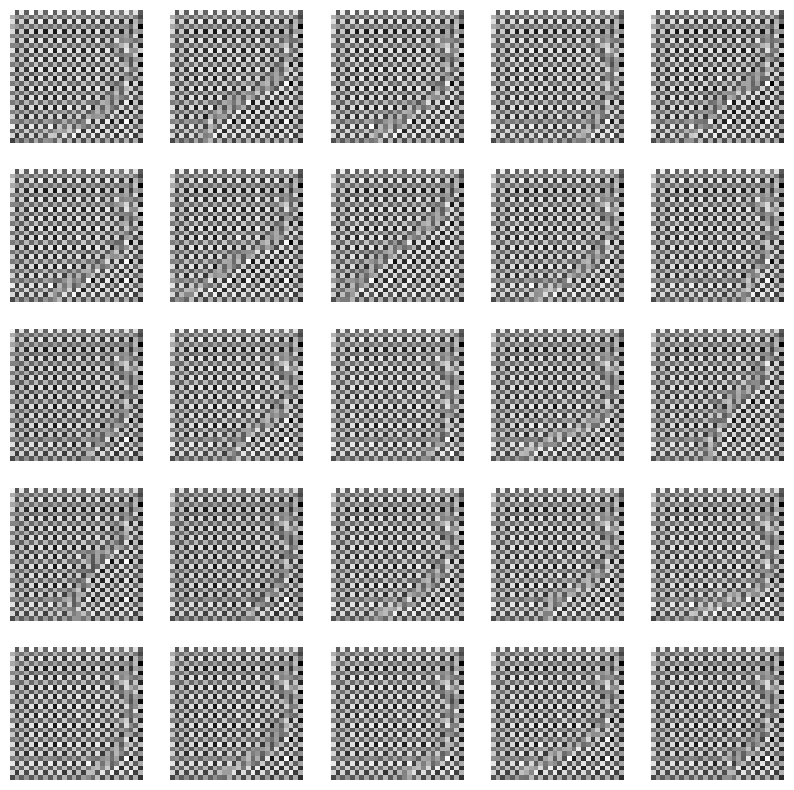

In [16]:
predict(model)

In [17]:
def predict_step(model, timesteps=50, num_samples=8):
    xs = []
    x = np.random.normal(size=(num_samples, 28, 28, 1))  # Ajustado para Fashion MNIST

    for i in trange(timesteps):
        t = np.full((num_samples, 1), i)  # Tempo como vetor coluna
        x = model.predict([x, t], verbose=0)
        if i % 5 == 0:  # Salva a cada 5 passos para reduzir o número de imagens
            xs.append(x[0])

    # Normaliza as imagens para o intervalo [0, 1]
    xs = [(x - x.min()) / (x.max() - x.min()) for x in xs]

    plt.figure(figsize=(20, 3))
    for i, img in enumerate(xs):
        plt.subplot(1, len(xs), i+1)
        plt.imshow(cvtImg(img), cmap='gray')
        plt.title(f'Step {i*5}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

  0%|          | 0/50 [00:00<?, ?it/s]

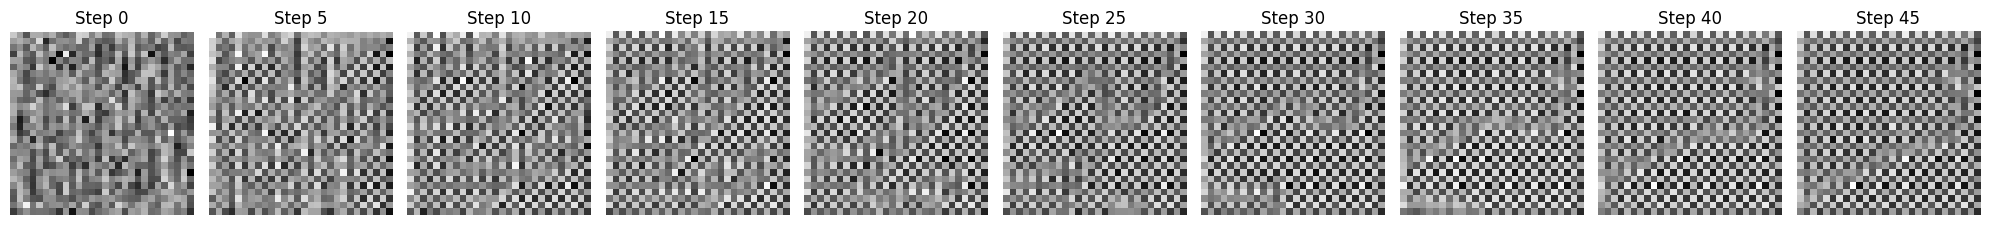

In [18]:
predict_step(model)

## Vídeo 3.4 - Treinando a U-Net

In [21]:
def train_one(x_img):
    x_ts = generate_ts(len(x_img))
    x_a, x_b = forward_noise(x_img, x_ts)
    loss = model.train_on_batch([x_a, x_ts], x_b)
    return loss

In [19]:
def train(R=50):
    bar = trange(R)
    total = 100
    for i in bar:
        for j in range(total):
            x_img = X_treino[np.random.randint(len(X_treino), size=BATCH_SIZE)]
            loss = train_one(x_img)
            pg = (j / total) * 100
            if j % 5 == 0:
                bar.set_description(f'loss: {loss:.5f}, p: {pg:.2f}%')

  0%|          | 0/50 [00:00<?, ?it/s]

2024-09-17 14:20:17.316127: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f27f577fa40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-09-17 14:20:17.316164: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA L4, Compute Capability 8.9
2024-09-17 14:20:17.338749: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1726582817.473739    3485 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

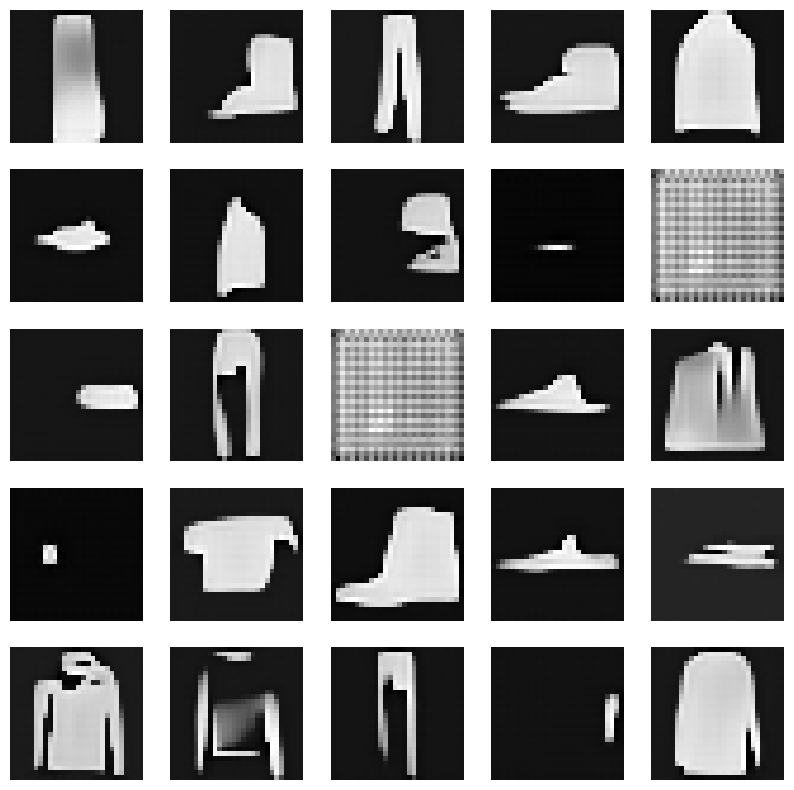

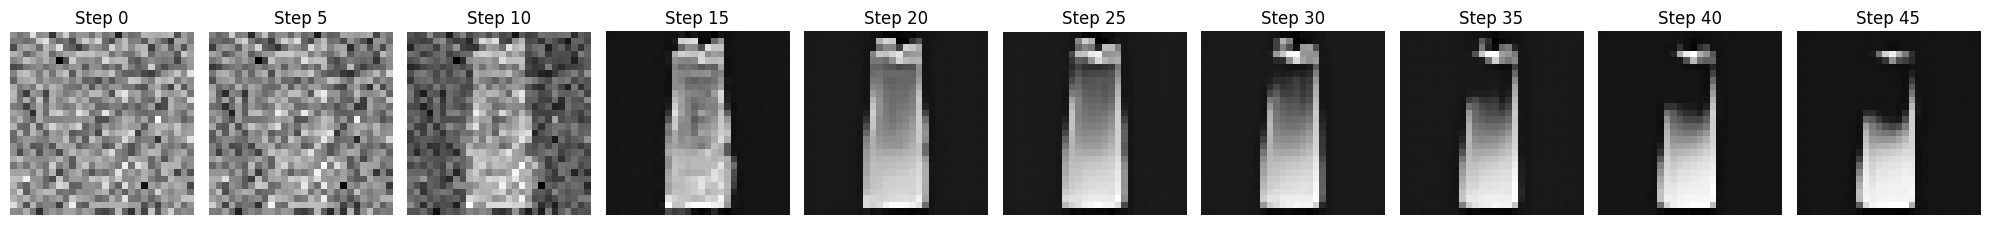

In [22]:

train()



predict(model)
predict_step(model)